In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

WA_Fn-UseC_-HR-Employee-Attrition.csv



In [2]:
full = pd.read_csv('../input/WA_Fn-UseC_-HR-Employee-Attrition.csv')
full.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
full.isnull().sum()
full=full.replace({"Attrition": {"Yes":1, "No":0}})

In [4]:
full=full.drop("Over18",axis=1)
full=full.replace({
    "OverTime": {"Yes":1, "No":0}
})
full=full.drop("StandardHours",axis=1)
full["Male"]=full["Gender"].map(lambda x: 1 if x=="Male" else 0)
full=full.drop("Gender",axis=1)

In [5]:
categorical_features = full.select_dtypes(include = ["object"]).columns
numerical_features = full.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("Attrition")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

Numerical features : 27
Categorical features : 5


In [6]:
full_num = full[numerical_features]
full_cat = full[categorical_features]

In [7]:
from scipy.stats import skew
skewness = full_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")

15 skewed numerical features to log transform


In [8]:
skewed_features = skewness.index
full_num[skewed_features] = np.log1p(full_num[skewed_features])

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [9]:
full_cat = pd.get_dummies(full_cat)
#
X=pd.concat([full_num,full_cat],axis=1)
print("New Features:"+str(X.shape[1]))
Y=full.Attrition

New Features:51


In [10]:
from sklearn.model_selection import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))


X_train : (1029, 51)
X_test : (441, 51)
y_train : (1029,)
y_test : (441,)


In [11]:
# Standardize numerical features
from sklearn.preprocessing import StandardScaler
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


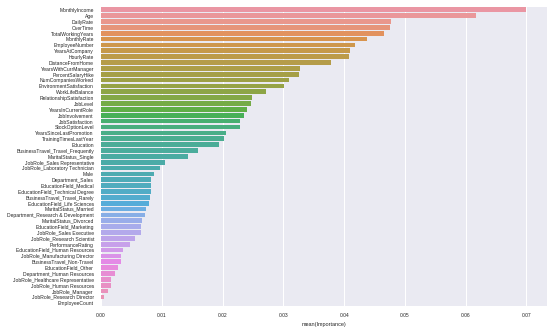

In [12]:
#randomForest
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100,max_features=7)
rf.fit(X_train,y_train)
rf.score(X_train,y_train)
rf.score(X_test,y_test)
Imp=rf.feature_importances_
Importance=pd.DataFrame(Imp,index=X_train.columns,columns=["Importance"])
Importance=Importance.sort_values(by="Importance",ascending=False)
sns.set(font_scale=.5)
sns.barplot(y=Importance.index,x=Importance.Importance)

In [13]:
import xgboost as xgb

In [14]:
dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test,label=y_test)
param={'max_depth':2,'eta':0.01,'subsampe':0.5,'objective':'binary:logistic','booster':'gbtree'}
watchlist=[(dtest,'eval'),(dtrain,'train')]
num_round=3000
bst=xgb.train(param,dtrain,num_round,watchlist)

[0]	eval-error:0.170068	train-error:0.14966
[1]	eval-error:0.170068	train-error:0.14966
[2]	eval-error:0.170068	train-error:0.14966
[3]	eval-error:0.170068	train-error:0.14966
[4]	eval-error:0.165533	train-error:0.145773
[5]	eval-error:0.165533	train-error:0.145773
[6]	eval-error:0.165533	train-error:0.145773
[7]	eval-error:0.165533	train-error:0.145773
[8]	eval-error:0.165533	train-error:0.145773
[9]	eval-error:0.165533	train-error:0.145773
[10]	eval-error:0.165533	train-error:0.145773
[11]	eval-error:0.165533	train-error:0.145773
[12]	eval-error:0.165533	train-error:0.145773
[13]	eval-error:0.156463	train-error:0.137998
[14]	eval-error:0.154195	train-error:0.141885
[15]	eval-error:0.151927	train-error:0.143829
[16]	eval-error:0.151927	train-error:0.143829
[17]	eval-error:0.151927	train-error:0.141885
[18]	eval-error:0.151927	train-error:0.141885
[19]	eval-error:0.151927	train-error:0.143829
[20]	eval-error:0.151927	train-error:0.143829
[21]	eval-error:0.151927	train-error:0.143829
[2

In [15]:
y_test_pred=bst.predict(dtest)
y_test_pred[y_test_pred>0.5]=1
y_test_pred[y_test_pred<=0.5]=0
y_train_pred=bst.predict(dtrain)
y_train_pred[y_train_pred>0.5]=1
y_train_pred[y_train_pred<=0.5]=0
print("Accurary on Training set :", sum(y_train_pred==y_train)/len(y_train))
print("Accurary on Test set :",sum(y_test_pred==y_test)/len(y_test))

Accurary on Training set : 0.950437317784
Accurary on Test set : 0.873015873016
